In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import plotly.express as px
import os

import sklearn.linear_model

import matplotlib.pyplot as plt
%matplotlib inline

# Trip generation

The purpose of this notebook is to give the student a basic understand of how a growth-factor-based trip generation model works and how it can be applied to data.

First, let's load the population, commuting, and municipality data from the last exercise:

In [14]:
df_population = pd.read_parquet("population.parquet")
df_commutes = pd.read_parquet("commutes.parquet")

# geopandas
df_munipalities = gpd.read_parquet("municipalities.parquet")

**Task**: To reduce the amount of computation, filter all three data sets for the Île-de-France region. For the commuting data, make sure to only keep movements where both origin and destination are within the region.

In [15]:
idf_departments = ["75", "92", "93", "94", "95", "77", "91", "78"]

In [16]:
# Insert code here ...
# ...

df_population = df_population[df_population["municipality_id"].str[:2].isin(idf_departments)]
df_munipalities = df_munipalities[df_munipalities["municipality_id"].str[:2].isin(idf_departments)]

df_commutes = df_commutes[
    df_commutes["origin_id"].str[:2].isin(idf_departments) &
    df_commutes["destination_id"].str[:2].isin(idf_departments)
]

## Simple model

**Task**: Implement the simple trip generation model as described during the lecture:

$$
O_i = \beta N_i
$$

with $O_i$ indicating the outflow (the number of commuters) of a municipality and $N_i$ its population count. To estimate, $\beta$, the following formula has been established:

$$
\beta = \frac{\sum_i \hat O_i \cdot N_i}{\sum_i N_i^2}
$$

with $\hat O_i$ as the reference commuters known from data.

In [134]:
# Hint: Working with multiple data frames is easier if we know that the order with respect to the keys is the same. We can do so by indexing our data sets:
municipalities = df_munipalities["municipality_id"].unique()

df_population = df_population.set_index("municipality_id").reindex(municipalities)

KeyError: "None of ['municipality_id'] are in the columns"

In [45]:
# Insert code here ...
# ...

# nominator = 
# denominator = 
# beta =

df_origins = df_commutes.groupby("origin_id")["weight"].sum().reset_index()
df_origins = df_origins.set_index("origin_id").reindex(municipalities)

O = df_origins["weight"].values
N = df_population["population"].values

nominator = np.sum(O * N)
denominator = np.sum(N**2)

beta = nominator / denominator
beta

0.45520431866853267

**Task**: Generate the flows using your model.

In [47]:
# Insert code here ...
# ...

# O_generated = ...

O_generated = beta * N

**Task**: Plot the fit of your model as a scatter plot (x = reference, y = model).

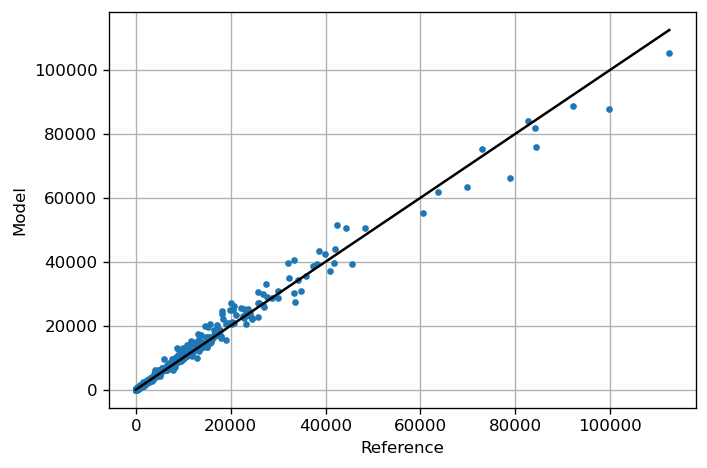

In [53]:
# Insert code here ...
# ...

plt.figure(dpi = 120, figsize = (6, 4))

plt.plot(O, O_generated, ".")
plt.plot([0, np.max(O)], [0, np.max(O)], "k")

plt.grid()
plt.xlabel("Reference")
plt.ylabel("Model")

plt.tight_layout()

**Task**: Let's test the ability to generalize of the model.
- Shuffle the order of the municipalities
- Take 30% as the validation data set
- Take the remaining 70% as the training data set
- Use 20%, 40%, 60%, 80%, 100% of the training data set to estimate the model
- For each case, note the model fit on the validation data $(O_i - \hat O_i)^2$

## CSP Model

**Task**: Implement the CSP-based growth model for trip distribution as it was introduced in the lecture.

- Prepare the input data and reference data
- Set up the model
- Show the coefficients and the offset
- What do you observe? Which impact do individual CSP have on the commutes?

Hint: Make use of `sklearn.linear_model.LinearRegression`

In [135]:
# Insert code here ...
# ...

# Set up the model input data (features)
# X =

# Set up the reference data (labels / ground truth)
# y = 

# Set up the sklearn model
# model = 

X = df_population.reindex(municipalities).values[:,1:]
y = df_origins.reindex(municipalities)["weight"].values

model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

model.coef_, model.intercept_

(array([ 0.31916312,  0.99386541,  0.86289528,  0.99020154,  0.77994385,
         0.70818974,  0.12007015, -0.07342635]),
 27.243935591221998)

**Task**: Apply the model to the population data without using sklearn, but just making use of the parameters. Show the fit with the reference data

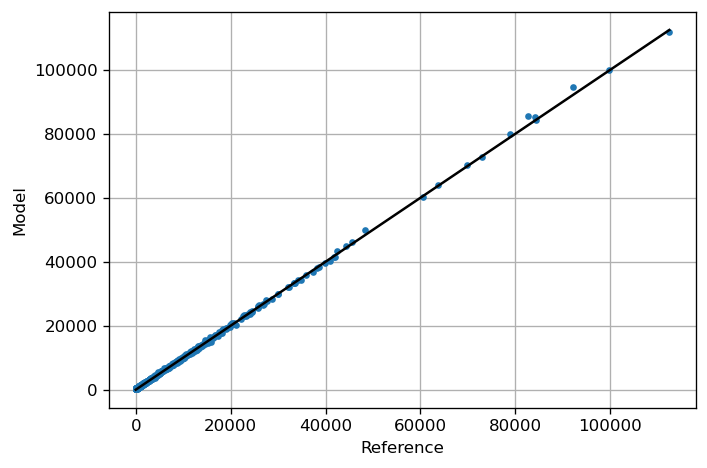

In [137]:
# Insert code here ...
# ...

# coefficients = 
# intercept = 

# prediction = 

coefficients = model.coef_
intercept = model.intercept_

prediction = np.maximum(np.sum(intercept + X * coefficients[np.newaxis, :], axis = 1), 0.0)

plt.figure(dpi = 120, figsize = (6, 4))

plt.plot(y, prediction, ".")
plt.plot([0, np.max(O)], [0, np.max(O)], "k")

plt.grid()
plt.xlabel("Reference")
plt.ylabel("Model")

plt.tight_layout()

**Bonus task:** Now we have a model that generates the number of outgoing commuters per day, based on the composition of the population in a zone. As a bonus task, go back to the population data from the previous task. Remember that it gave us the number of people in a CSP per IRIS, not only per municipality. Use the model that we have estimated now to generate the number of commuters per IRIS in Île-de-France.

<Axes: >

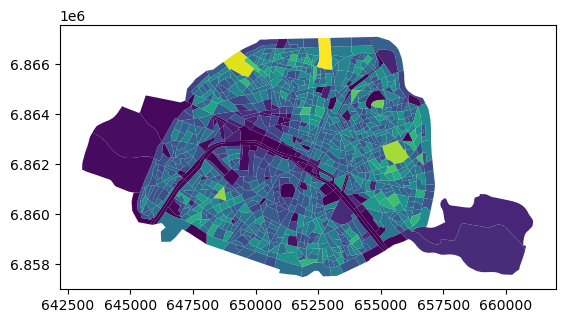

In [164]:
# Insert code here ...
# ...

df_iris = gpd.read_file("CONTOURS-IRIS.shp")
df_iris = df_iris[["INSEE_COM", "CODE_IRIS", "geometry"]].rename(columns = {
    "INSEE_COM": "municipality_id", "CODE_IRIS": "iris_id"
})

df_iris_population = pd.read_csv("base-ic-evol-struct-pop-2019.CSV", sep = ";", dtype = {
    "IRIS": "str"
}, usecols = ["IRIS"] + ["C19_POP15P_CS{}".format(k) for k in range(1,9)])

for k in range(1, 9):
    df_iris_population["csp_{}".format(k)] = df_iris_population["C19_POP15P_CS{}".format(k)]
    
df_iris_population = df_iris_population[["IRIS"] + ["csp_{}".format(k) for k in range(1,9)]]
df_iris_population.columns = ["iris_id"] + ["csp_{}".format(k) for k in range(1,9)]
df_iris_population = df_iris_population.groupby("iris_id").sum().reset_index()

df_iris_population["commuters"] = np.maximum(
    np.sum(intercept + df_iris_population.values[:,1:] * coefficients[np.newaxis, :], axis = 1), 0.0)

df_matched = pd.merge(df_iris[
    df_iris["iris_id"].str[:2] == "75"
], df_iris_population, on = "iris_id")

df_matched["commuters"] = df_matched["commuters"].astype(float)
df_matched.plot("commuters")

**Congratulations**, you can now solve Exercise 2.1 of the course project.